### Importation of dependencies

ZAT describes the air temperature, c is the measurement of air temperature, celsius

In [170]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime as dt
from sp_ql import Engine
from matplotlib.pyplot import figure

### Client and building name definition

Project is the client, keyname_01 the buildingID. Below are project,keyname_01 combinations for all 25 office buildings in the portfolio. 15 of these are from client: Merin, 10 from client: NSI

### Pulling unique sensors per building for NSI

In [96]:
client='NSI'
sensors_NSI={}
engine = Engine(project=project, isAsync=False)
nsi_projects_list=['FOKKERWG','BENNEK41','RADPAMS','R003331','AVS_UTR','P163063','PARI_ADM','P2639','DIEMEN','ROME_ADM']
for i in nsi_projects_list:
    bms_registers = engine.list().filter(keyname_01=i).all()
    sensors=bms_registers.loc[bms_registers['Client'] == client]
    sensors_NSI[i]=sensors['BRICK_class'].unique()

### Pulling unique sensors per building for MERIN

In [125]:
client='Merin'
sensors_MERIN={}
engine = Engine(project=client, isAsync=False)
merin_projects_list=['SPICALN1','WEND_163','KRSD8ADM','OVSAM186','OVSAM184','HGHW8ADM','HGHW4ADM','CRBA_CAP','CRBB_CAP','OVSAM61',
                  'GPR_EH', 'POLAR130', 'VOGELSTR', 'AQUARIUS', 'TRW32ADM']
for i in merin_projects_list:
    bms_registers = engine.list().filter(keyname_01=i).all()
    sensors=bms_registers.loc[bms_registers['Client'] == client]
    sensors_MERIN[i]=sensors['BRICK_class'].unique()

### Pulling sensor data together for NSI and MERIN

In [200]:
vals = {}                      
for i in sensors_MERIN.values():
    for j in set(i):             
        vals[j] = 1 + vals.get(j,0) 
for i in sensors_NSI.values():
    for j in set(i):
        vals[j] = 1 + vals.get(j,0)
vals #dictionary of number of counts of sensors from NSI and MERIN portfolio

{'Zone Air Temperature Sensor': 25,
 'Motion Sensor': 19,
 'Luminance Sensor': 21,
 'Zone Air Humidity Sensor': 24,
 'Battery Voltage Sensor': 24,
 'CO2 Sensor': 8,
 'Electrical Power Sensor': 2}

In [201]:
vals=dict(sorted(vals.items(), key=lambda item: item[1]))

In [202]:
vals

{'Electrical Power Sensor': 2,
 'CO2 Sensor': 8,
 'Motion Sensor': 19,
 'Luminance Sensor': 21,
 'Zone Air Humidity Sensor': 24,
 'Battery Voltage Sensor': 24,
 'Zone Air Temperature Sensor': 25}

Text(0, 0.5, 'Sensor count')

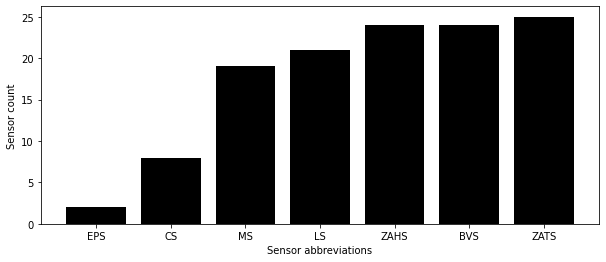

In [287]:
sensors,sensors2 = list(vals.keys()), []
for i in sensors:
    line=i
    words=i.split()
    letters = [word[0] for word in words]
    sensors2.append("".join(letters))
counts = list(vals.values())
figure(figsize=(10, 4))
plt.bar(sensors2, counts, color="black")
#plt.title("Sensor counts for all 25 office-buildings")
plt.xlabel("Sensor abbreviations")
plt.ylabel("Sensor count")

In [208]:
line = "I like to play guitar and piano and drums"
words = line.split()
letters = [word[0] for word in words]
print ("".join(letters))

Iltpgapad


### Selection of client and building

In [224]:
project, keyname_01 = 'MERIN', 'SPICALN1'
#project, keyname_01 = 'MERIN', 'WEND_163'
#project, keyname_01 = 'MERIN', 'KRSD8ADM'
#project, keyname_01 = 'MERIN', 'OVSAM186'
#project, keyname_01 = 'MERIN', 'OVSAM184'
#project, keyname_01 = 'MERIN', 'HGHW8ADM'
#project, keyname_01 = 'MERIN', 'HGHW4ADM'
#project, keyname_01 = 'MERIN', 'CRBA_CAP'
#project, keyname_01 = 'MERIN', 'CRBB_CAP'
#project, keyname_01 = 'MERIN', 'OVSAM61'
#project, keyname_01 = 'MERIN', 'GPR_EH'
#project, keyname_01 = 'MERIN', 'POLAR130'
#project, keyname_01 = 'MERIN', 'VOGELSTR'
#project, keyname_01 = 'MERIN', 'AQUARIUS'
#project, keyname_01 = 'MERIN', 'TRW32ADM'

#project, keyname_01 = 'NSI', 'FOKKERWG'
#project, keyname_01 = 'NSI', 'BENNEK41'
#project, keyname_01 = 'NSI', 'RADPAMS'
#project, keyname_01 = 'NSI', 'R003331'
#project, keyname_01 = 'NSI', 'AVS_UTR'
#project, keyname_01 = 'NSI', 'P163063'
#project, keyname_01 = 'NSI', 'PARI_ADM'
#project, keyname_01 = 'NSI', 'P2639'
#project, keyname_01 = 'NSI', 'DIEMEN'
#project, keyname_01 = 'NSI', 'ROME_ADM'

### Date and time definitions

In [257]:
#before=dt.datetime.now() #viewing data before this date
#american data formatting
before=dt.datetime(2022,3,10, 0, 0) #viewing data after this data, up until before
after=dt.datetime(2022,1,10, 0, 0) #viewing data after this data, up until before
time_res='15T' #15 minute time invervals are checked for which sensor data is recorded

### Basic sensor information 

In [226]:
engine = Engine(project=project, isAsync=False)
bms_registers = engine.list().filter(keyname_01=keyname_01).all() #gives basic sensor information concerning the building defined above
#data is on the server, engine object is empty but can be thought of as a "basket" which can call the data for you from the server

### Downloading Air Temperature Data

In [239]:
zat_uuids = bms_registers[bms_registers['BRICK_class']=='Zone Air Temperature Sensor']['uuid'].unique() #each air temperature sensor has a unique id
zats = pd.DataFrame()
zats_meta = {} # joining the dfs makes them lose their metadata; by preserving them in a dict the meta data is also stored

for zat_uuid in zat_uuids: #goes through the sensors one by one, doesn't retrive everything in one go due to server restriction
    if len(zats) == 0:
        #the measurement for celcius air temperature data is stored as kW; which is a measurement of power
        #for this reason, the mean of the air temperatures is taken and not the sum(), as kW is not a measurement of consumption
        zats = engine.select(zat_uuid) \
               .group_by(time_res).mean().after(after).before(before).all()
        zats_meta[zat_uuid] = zats.metadata[zat_uuid]
    else:
        zat = engine.select(zat_uuid) \
               .group_by(time_res).mean().after(after).before(before).all()
        zats = zats.join(zat)
        zats_meta[zat_uuid] = zat.metadata[zat_uuid]
        
# this gets rid of sensors with no floor data (not spectral sensors)
for c in zats.columns:
    if 'floor' not in zats_meta[c].keys():
        del zats[c]
        
#extracts thermal_zone and sensor_id from meta_data for each sensor
#this is stored in zat_uuid_lookup dictionary
zat_uuid_lookup = {}
for c in zats.columns:
    tz = zats_meta[c]['thermal_zone']
    si = zats_meta[c]['sensor_id']
    plot_label = f'{tz}_{si}'
    zats.rename(columns={c:plot_label}, inplace=True)
    zat_uuid_lookup[f'{tz}_{si}'] = c

### Downloading Motion Sensor Data

In [258]:
# same process but now for motion sensors
mot_uuids = bms_registers[bms_registers['BRICK_class']=='Motion Sensor']['uuid'].unique()
mots = pd.DataFrame()
mots_meta = {} #extra data stored on the sp-ql relating: meta-data
for mot_uuid in mot_uuids:
    if len(mots) == 0:
        mots = engine.select(mot_uuid) \
               .group_by(time_res).mean().after(after).before(before).all()
        mots_meta[mot_uuid] = mots.metadata[mot_uuid]
    else:
        mot = engine.select(mot_uuid) \
               .group_by(time_res).mean().after(after).before(before).all()
        mots = mots.join(mot)
        mots_meta[mot_uuid] = mot.metadata[mot_uuid]
        
# this gets rid of sensors with no floor data (not spectral sensors)
for c in mots.columns:
    if 'floor' not in mots_meta[c].keys():
        del mots[c]
        
#extracts thermal_zone and sensor_id from meta_data for each sensor
#this is stored in mot_uuid_lookup dictionary     
mot_uuid_lookup = {}
for c in mots.columns:
    tz = mots_meta[c]['thermal_zone']
    si = mots_meta[c]['sensor_id']
    plot_label = f'{tz}_{si}' 
    mots.rename(columns={c:plot_label}, inplace=True)
    mot_uuid_lookup[f'{tz}_{si}'] = c

### Basic plot data

In [229]:
# definition of min temp threshold
min_temp = pd.Series(index=zats.index, data=20.5)

# determines number of uniue floors, so the plot knows how many plots to make
floors = bms_registers['floor'].unique()
floors = floors[~np.isnan(floors.astype(float))].astype(int)
floors = np.sort(floors)

# interpolation
zats = zats.interpolate() # connecting of the dots 
# for temperature sensors, if the temperature stays the same across a shot time interval then a "nan" is recorded

### Plot

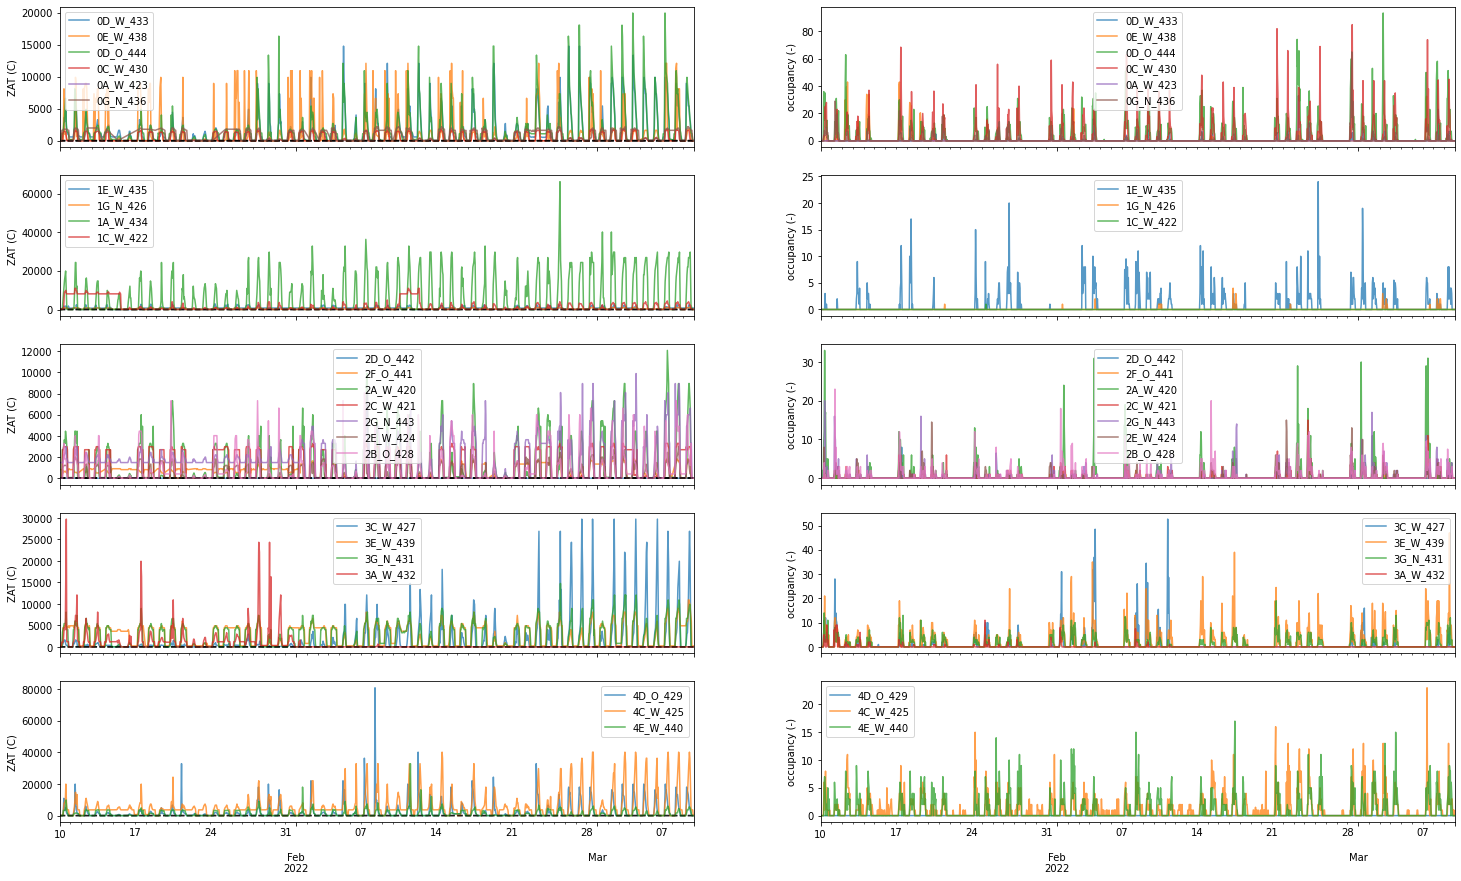

In [231]:
fig, ax = plt.subplots(floors.max() + 1, 2, sharex=True)
for c in zats.columns:
    floor = zats_meta[zat_uuid_lookup[c]]['floor']
    zats[[c]].plot(ax=ax[int(floor)][0], alpha=0.75)
    if c in mots.columns:
        mots[[c]].resample('60T').sum().plot(ax=ax[int(floor)][1], alpha=0.75)
    min_temp.plot(ax=ax[int(floor)][0], color='k', alpha=0.5, linestyle="--")
    ax[int(floor)][0].set_ylabel('ZAT (C)')
    ax[int(floor)][1].set_ylabel('occupancy (-)')
#fig.suptitle(keyname_01)
fig.set_size_inches(25, 15)
plt.show(block=False)